<a href="https://colab.research.google.com/github/kimgeonhee317/stable-diffusion-lec-notes/blob/main/notebook/lec_note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Stable diffusion basics

### Types of Image generation
1. Unconditional image generation: model just generates images without any additional condition like text and image. You will get images similar to provided in the training set.

2. Based on text : text to image, text2img
The prompt is converted to embedding

3. Based on image : image to image, img2img

### Diffusion Model
1. Diffusion models are essentially Markov chains trained using variational inference.
2. The purpose of diffusion models is to learn the latent structure of a dataset by modeling the way data points diffuse through the latent space
3. In the field of computer vision, this means that a neural network is trained to reduce noise from images blurred with Gaussian noise by learning how to reverse the diffusion process.
4. In other words, it is the process that will transform noise (the initial state) into generated image (the result)

### Autoencoders
Intorduced as a powerful tool to compress images or data in general.
- Encoder: converts the input into lower-dimensional latent vector, usually through standard convolutions and clustering layers.
- Decoder: performs operations such as deconvolution and upsampling to try to reconstruct the input image

### Variational autoencoders
+ The encoder returns the mean and the standard deviation for each input; then, the latent vector is sampled from this distribution and sent to the decoder to reconstruct the input
+ Training is now controlled by reconstruction loss and similarity loss, which is the KL divergence between the latent space distribution and the standard Gaussian.
+ VAEs are trained not only to reconstruct images, but also to produce latent vectors from a normal distribution

### U-NET
+ encoder: the first part and it is usually a pre-trained classification network (like VGG/ResNet).
Convolution blocks followed by maxpool/downsampling are applied to encode the input image into feature representations at several different levels

+ decoder: it is the second part of the architecture, which has the goal to semantically project the discriminative features (lower resolution) learned by the encoder into pixel space (higher resolution) to obtain a dense classification. The decoder consists of upsampling and concatenation followed by regular convolution operations.

### Text-encoder
+ The text-encoder is responsible for turning the input prompt into a embedding space that can be understood by U-net.
+ It is usally a simple transformer=based encoder that maps a squence of input tokens to a sequence of latent text-embeddings.
+ Inspired by Imagen, Stable diffusion does not train the text encoder during training, it simply uses an already trained CLIP text encodert, the **CLIPTextModel**

### Stable diffusion inference
+ SD receives a latent seed and a text prompt as input
+ The seed is used to generate random represntations of latent images of size 64 * 64 (4096)
+ The text prompt is transformed into text embeddings of size 77 * 768 using CLIP text encoder. (Maximum sequence word numbers is 77)
+ U-net iteratively reduces noise from the random latent image representations while conditioning on the text embeddings. => Text conditioned latent Unet
+ The U-Net output(noise residual) is used to compute a denoised latent image representation using a scheduler algorithm.
+ The denoising process is prepeated x times to recover the best latent image representations.
+ Once completed, the latent image representation is decoded by the decoder part of the VAE



### Recap Components
+ text encoder: Stable diffusion uses CLIP, but other diffusion models can use other encoders like BERT.
+ tokenizer: It must match the one used by the text_encoder model.
+ scheduler: The scheduler algorithm used to progressively add noise to the image during training
+ u-net: The model used to generate the latent representation of the input.
+ vae: Autoencoder module that we will use to decode latentrepresentations into real images.


### Scheduler algorithms
+ Scheduler algorithms (also called samplers) calculates the predicted denosied image representation from the previous noise representation and the predicted residual noise.
+ Determines how the image is calculated.
+ There are several different algorithms. Some examples commonly used with stable diffusion.
  + PNDM (default)
  + DDIM scheduler
  + K-LMS scheduler
  + Euler Ancestral Discrete Scheduler
  + DPM Scheduler



## 2. Implementation

License Summary:

```
1. You can't use the model to deliberately produce nor share illegal or harmful outputs or content,
2. We claim no rights on the outputs you generate, you are free to use them and are accountable for their use which should not go against the provisions set in the license, and
3. You may re-distribute the weights and use the model commercially and/or as a service. If you do, please be aware you have to include the same use restrictions as the ones in the license and share a copy of the CreativeML OpenRAIL-M to all your users.
```
(Licence of v1.4 e v1.5 https://huggingface.co/spaces/CompVis/stable-diffusion-license)


In [1]:
# check the gpu google provided
!nvidia-smi

Mon Aug 28 15:09:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install libraries

In [5]:
# xformers for memory optimization
!pip install diffusers==0.11.1
!pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.0/167.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 33.8 MB/s eta 0:

### Pipeline for image generation


In [7]:
import torch #pytorch library
from diffusers import StableDiffusionPipeline

In [9]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)

safety_checker/pytorch_model.fp16.safetensors not found


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [10]:
pipe = pipe.to('cuda')

In [11]:
pipe.enable_attention_slicing()
pipe.enable_xformers_memory_efficient_attention()

### Prompts
+ A prompt is set of text instructions given to a deep learning algorithm to produce output.

+ One of the key aspects of AI image generation is that you need to master the technique of how to create effective text prompts

+ The specialization in this technique is known today as Prompt engineering




### Building a good prompt
You need to exactly describe how you want the image (using a lot of details)
1. Describe the subject in detail.
2. Make sure to include powerful keywords to define the style you are looking for in the final image.

Being more specific, the anatomy of a good prompt should cover most of these features.
1. Subject / Object
2. Action and Local
3. Type
4. Style
5. Colors
6. Artist
7. Resolution
8. Website
9. Other features...

Some websites where you will find the prompts..

### Creating the prompt

In [12]:
prompt = 'an apple'

### Generating the image

In [16]:
img = pipe(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
type(img)

PIL.Image.Image

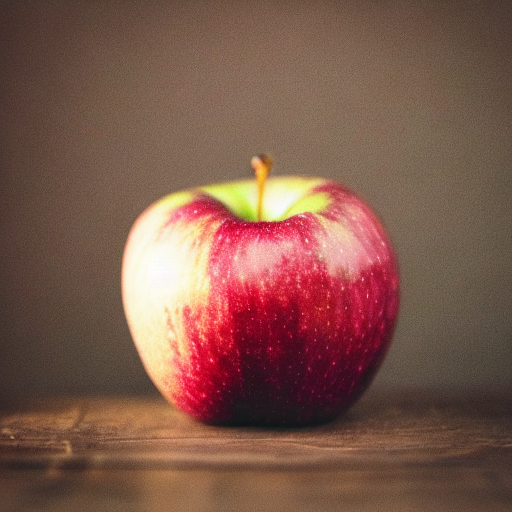

In [17]:
img

  0%|          | 0/50 [00:00<?, ?it/s]

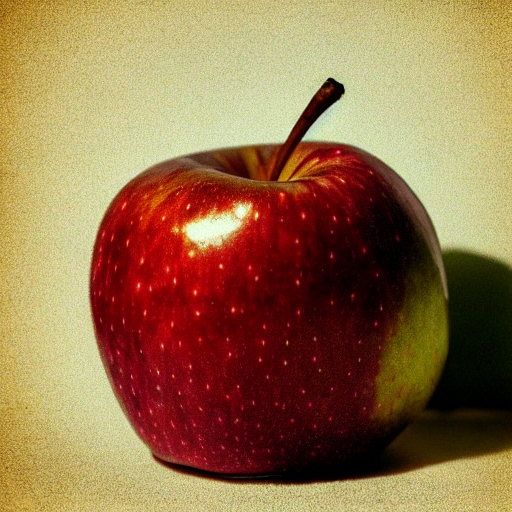

In [19]:
prompt='photograph of an apple'
img = pipe(prompt).images[0]
img

### Saving the result

In [20]:
img.save('result.png')

  0%|          | 0/50 [00:00<?, ?it/s]

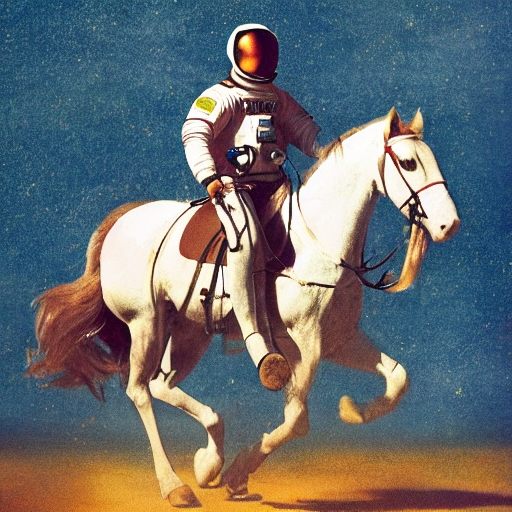

In [23]:
prompt = 'a photograph of an astronaut riding a horse, color'
img = pipe(prompt).images[0]
img

In [24]:
img.size

(512, 512)

### Generating multiple images